## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('ethereum.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Close')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Open'].values.reshape(-1, 1)

df

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337
...,...
2022-05-28,1.72467
2022-05-29,1.79225
2022-05-30,1.81356


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = arima_sc.fit_transform(df_close)
df_scaled

,Open
Date,
2020-06-01,-1.394670
2020-06-02,-1.382460
2020-06-03,-1.390075
2020-06-04,-1.385081
2020-06-05,-1.385955
...,...
2022-05-28,-0.270140
2022-05-29,-0.219234
2022-05-30,-0.203182


# Vẽ đồ thị

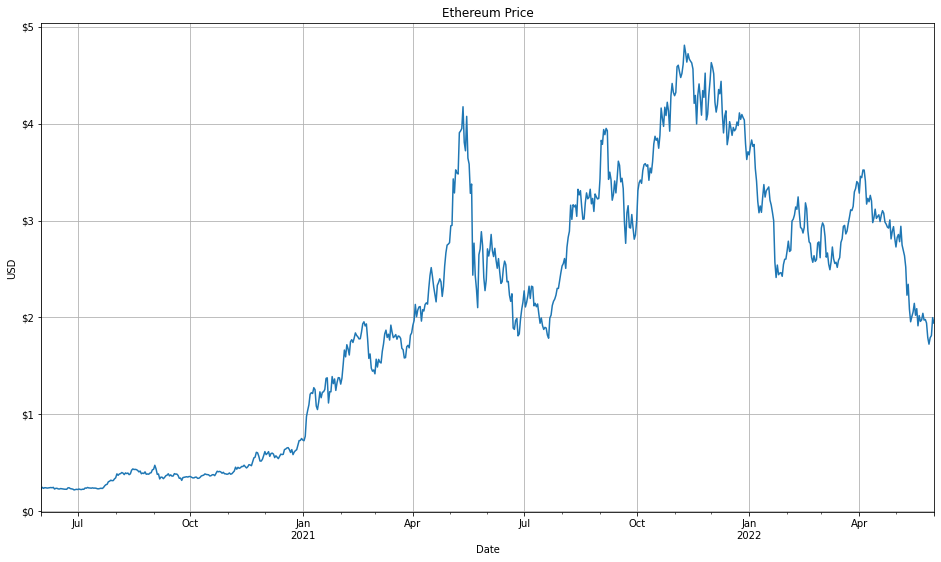

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Ethereum Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.7)], df_scaled[(int)(len(df_scaled) * 0.7):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.7):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (511, 1)
test shape:  (220, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Open'],'Ethereum Price')

Augmented Dickey-Fuller Test: Ethereum Price
ADF test statistic          0.030677
p-value                     0.960997
Number of lags used        16.000000
Number of observations    494.000000
critical value (1%)        -3.443657
critical value (5%)        -2.867408
critical value (10%)       -2.569896
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

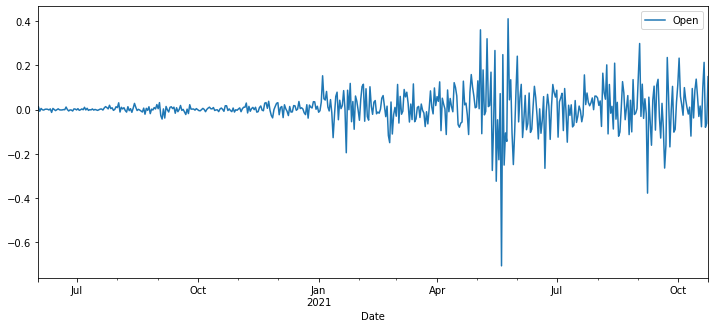

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Ethereum Price First Difference')

Augmented Dickey-Fuller Test: Ethereum Price First Difference
ADF test statistic       -6.567563e+00
p-value                   8.087059e-09
Number of lags used       1.500000e+01
Number of observations    4.940000e+02
critical value (1%)      -3.443657e+00
critical value (5%)      -2.867408e+00
critical value (10%)     -2.569896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1067.907, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1063.226, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1068.823, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1067.928, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1062.844, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1068.425, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1071.564, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1067.611, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1069.907, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1068.782, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1070.888, Time=0.26 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.813 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  511
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 539.782
Date:                Sun, 26 Jun 2022   AIC                          -1071.564
Time:                        23:52:59   BIC                          -1054.626
Sample:                             0   HQIC                         -1064.923
                                - 511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0106      0.007      1.583      0.113      -0.003       0.024
ar.L1         -0.8295      0.070    -11.772      0.000      -0.968      -0.691
ma.L1          0.7423      0.091      8.192      0.000       0.565       0.920
sigma2         0.0070      0.000     38.054      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              3100.78
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):             125.85   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([1.56605949, 1.58071991, 1.57916796, 1.59106422, 1.59180515,
       1.60179945, 1.60411806, 1.61280367, 1.61620784, 1.62399298,
       1.62814409, 1.63530964, 1.63997471, 1.64671393, 1.65173264,
       1.65817852, 1.66344055, 1.66968459, 1.67511405, 1.6812192 ,
       1.68676387, 1.69277346, 1.6983974 , 1.70434124, 1.71001971,
       1.71591831, 1.72163432, 1.72750178, 1.73324361, 1.73908965,
       1.74484925, 1.75068056, 1.75645238, 1.76227355, 1.76805378,
       1.77386797, 1.77965399, 1.78546338, 1.79125339, 1.79705947,
       1.80285222, 1.80865602, 1.81445066, 1.8202529 , 1.82604883,
       1.83185   , 1.83764682, 1.84344725, 1.84924469, 1.85504461,
       1.86084247, 1.86664203, 1.87244019, 1.87823951, 1.88403786,
       1.88983702, 1.89563551, 1.90143456, 1.90723314, 1.91303211,
       1.91883076, 1.92462967, 1.93042837, 1.93622724, 1.94202597,
       1.94782482, 1.95362356, 1.95942239, 1.96522116, 1.97101998,
       1.97681875, 1.98261756, 1.98841634, 1.99421514, 2.00001

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

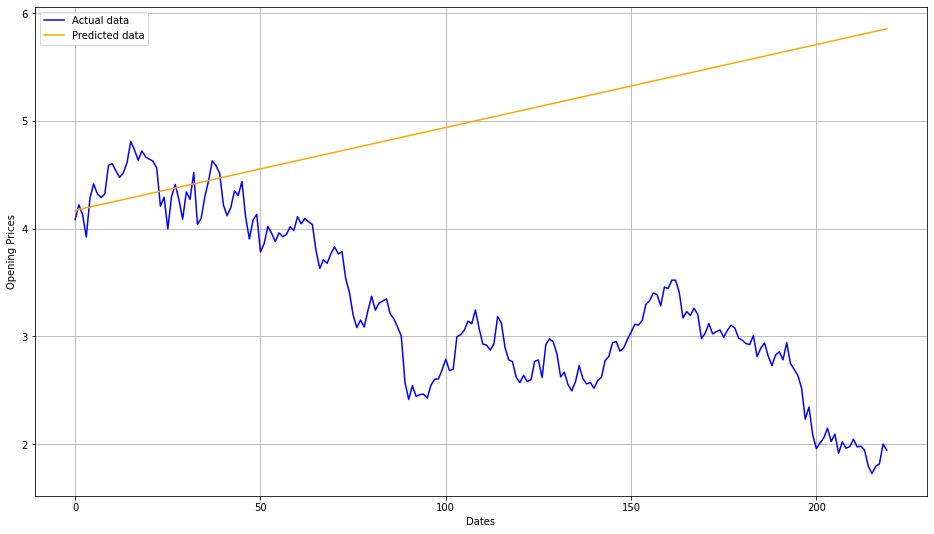

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1.80
MAPE: 67.73%
MSE: 4.56
RMSE: 2.14
R2: -6.55


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2021-10-25,4.08268,4.162316,-0.079636
2021-10-26,4.21992,4.181778,0.038142
2021-10-27,4.13006,4.179718,-0.049658
2021-10-28,3.92154,4.195511,-0.273971
2021-10-29,4.28490,4.196495,0.088405
...,...,...,...
2022-05-28,1.72467,5.823856,-4.099186
2022-05-29,1.79225,5.831554,-4.039304
2022-05-30,1.81356,5.839253,-4.025693


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2021-10-25,4.08268,4.162316,-0.079636
2021-10-26,4.21992,4.181778,0.038142
2021-10-27,4.13006,4.179718,-0.049658
2021-10-28,3.92154,4.195511,-0.273971
2021-10-29,4.28490,4.196495,0.088405
...,...,...,...
2022-05-28,1.72467,5.823856,-4.099186
2022-05-29,1.79225,5.831554,-4.039304
2022-05-30,1.81356,5.839253,-4.025693


# Vẽ đồ thị thể hiện sai số

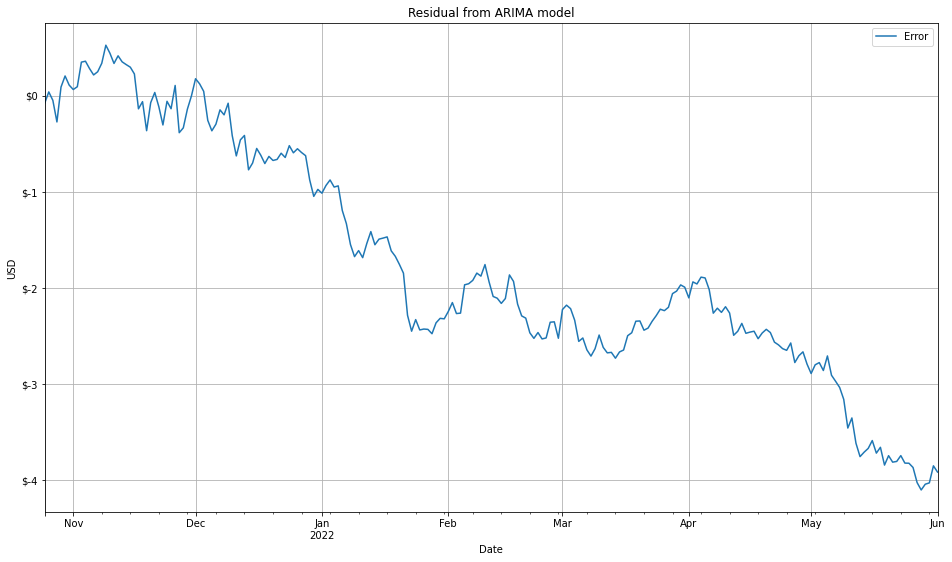

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[-7.96358877e-02],
       [ 3.81416706e-02],
       [-4.96580335e-02],
       [-2.73970907e-01],
       [ 8.84054719e-02],
       [ 2.03937535e-01],
       [ 1.09159472e-01],
       [ 6.30388810e-02],
       [ 9.19596851e-02],
       [ 3.47734518e-01],
       [ 3.57193715e-01],
       [ 2.80711088e-01],
       [ 2.14557985e-01],
       [ 2.47881328e-01],
       [ 3.35998752e-01],
       [ 5.23731524e-01],
       [ 4.40235915e-01],
       [ 3.34096644e-01],
       [ 4.13408764e-01],
       [ 3.50563868e-01],
       [ 3.21843049e-01],
       [ 2.95175015e-01],
       [ 2.24968963e-01],
       [-1.37601779e-01],
       [-6.31202398e-02],
       [-3.64970919e-01],
       [-7.35792019e-02],
       [ 3.23814469e-02],
       [-1.16191118e-01],
       [-3.05292032e-01],
       [-5.94381853e-02],
       [-1.36679533e-01],
       [ 1.05228083e-01],
       [-3.85739802e-01],
       [-3.35313353e-01],
       [-1.41211974e-01],
       [-2.65320934e-03],
       [ 1.75134544e-01],
       [ 1.2

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (217, 3, 1)
y_train (217, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("ethereum_7_3.h5")

Epoch 1/300
7/7 [==============================] - 3s 6ms/step - loss: 4.5244
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 4.2024
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 3.7615
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 3.0830
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0646
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6687
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4917
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2648
Epoch 9/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2701
Epoch 10/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2001
Epoch 11/300
7/7 [==============================] - 0s 6ms/step - loss: 0.1644
Epoch 12/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1466
Epoch 13/300
7/7 [==============================] - 0s 8ms/st

In [22]:
model = load_model("ethereum_7_3.h5")
error_pred = model.predict(x_train)
error_pred

7/7 [==============================] - 0s 3ms/step


array([[-0.07988742],
       [-0.2417393 ],
       [ 0.04261813],
       [ 0.11633825],
       [ 0.0623269 ],
       [ 0.03951702],
       [ 0.0564102 ],
       [ 0.2644737 ],
       [ 0.2656929 ],
       [ 0.22995138],
       [ 0.17935479],
       [ 0.20006323],
       [ 0.26489836],
       [ 0.42533886],
       [ 0.35384446],
       [ 0.29626676],
       [ 0.35861126],
       [ 0.28428236],
       [ 0.27475926],
       [ 0.24470949],
       [ 0.18265387],
       [-0.12019639],
       [-0.05376558],
       [-0.3358101 ],
       [-0.08984897],
       [-0.03768228],
       [-0.13306752],
       [-0.26469478],
       [-0.08292973],
       [-0.16916083],
       [ 0.05376881],
       [-0.3622974 ],
       [-0.28328648],
       [-0.18387061],
       [-0.05972385],
       [ 0.1038579 ],
       [ 0.0647764 ],
       [ 0.0201707 ],
       [-0.22611403],
       [-0.30836728],
       [-0.29168123],
       [-0.18577147],
       [-0.21800038],
       [-0.10271633],
       [-0.38412485],
       [-0

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2021-10-25,4.08268,4.162316,-0.079636,-0.079887
2021-10-26,4.21992,4.181778,0.038142,-0.241739
2021-10-27,4.13006,4.179718,-0.049658,0.042618
2021-10-28,3.92154,4.195511,-0.273971,0.116338
2021-10-29,4.28490,4.196495,0.088405,0.062327
...,...,...,...,...
2022-05-25,1.97940,5.800762,-3.821362,-4.064539
2022-05-26,1.94289,5.808460,-3.865570,-4.127844
2022-05-27,1.79319,5.816158,-4.022968,-4.106186


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2021-10-25,4.08268,4.162316,-0.079636,-0.079887,4.082428
2021-10-26,4.21992,4.181778,0.038142,-0.241739,3.940039
2021-10-27,4.13006,4.179718,-0.049658,0.042618,4.222336
2021-10-28,3.92154,4.195511,-0.273971,0.116338,4.311849
2021-10-29,4.28490,4.196495,0.088405,0.062327,4.258821
...,...,...,...,...,...
2022-05-25,1.97940,5.800762,-3.821362,-4.064539,1.736223
2022-05-26,1.94289,5.808460,-3.865570,-4.127844,1.680616
2022-05-27,1.79319,5.816158,-4.022968,-4.106186,1.709972


# Vẽ đồ thị

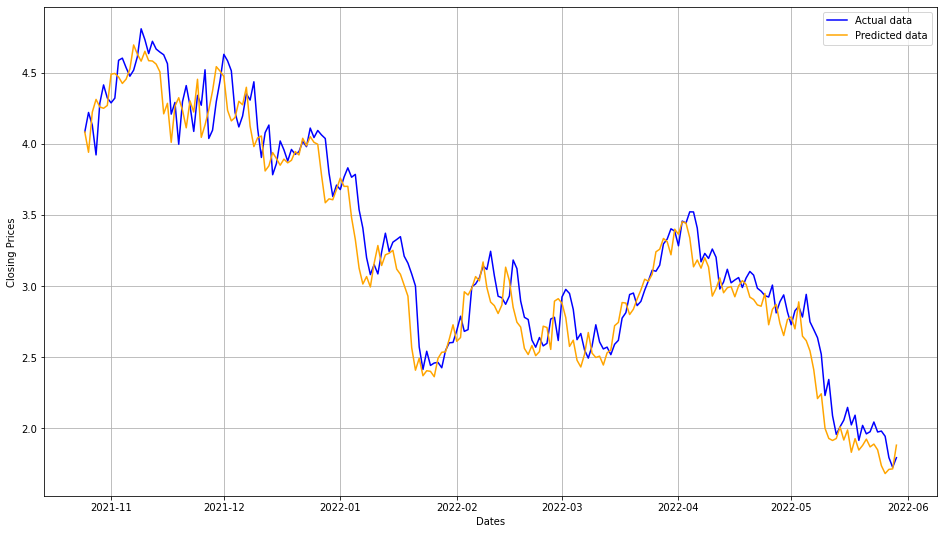

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.15
MAPE: 4.65%
MSE: 0.04
RMSE: 0.19
R2: 0.94


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -4.022968
2022-05-28   -4.099186
2022-05-29   -4.039304
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-4.02296805],
        [-4.09918623],
        [-4.03930442]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 29ms/step


array([-4.106187], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,1.79225,5.831554,-4.039304


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,1.79225,5.831554,-4.039304,1.725368


# Ghi ra file csv

In [32]:
df.to_csv("eth_processed_data_7_3.csv")
df_scaled.to_csv("eth_scaled_data_7_3.csv")
df_pred.to_csv("eth_ARIMA-PRED_7_3.csv")
df_lstm.to_csv("eth_LSTM_PRED_7_3.csv")
y_arima.to_csv("eth_Forecast_7_3.csv")